In [28]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.font_manager as fm

In [29]:
sample = pd.read_csv(r'electricity_data\sample_submission.csv')
train_df = pd.read_csv(r'electricity_data\train.csv', encoding='cp949')
test_df = pd.read_csv(r'electricity_data\test.csv', encoding='cp949')

In [19]:
sample.head()

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0


In [20]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [21]:
test_df.head()
# 3시간마다 한번씩 계측하였음.

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 데이터 split

In [22]:
# '비전기냉방설비운영'이 0이고 '태양광보유'가 0인 데이터만 선택
train_00 = train_df[(train_df['비전기냉방설비운영'] == 0) & (train_df['태양광보유'] == 0)]

# '비전기냉방설비운영'이 0이고 '태양광보유'가 1인 데이터만 선택
train_01 = train_df[(train_df['비전기냉방설비운영'] == 0) & (train_df['태양광보유'] == 1)]

# '비전기냉방설비운영'이 1이고 '태양광보유'가 0인 데이터만 선택
train_10 = train_df[(train_df['비전기냉방설비운영'] == 1) & (train_df['태양광보유'] == 0)]

# '비전기냉방설비운영'이 1이고 '태양광보유'가 1인 데이터만 선택
train_11 = train_df[(train_df['비전기냉방설비운영'] == 1) & (train_df['태양광보유'] == 1)]


In [23]:
train_df.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean()

비전기냉방설비운영  태양광보유
0.0        0.0      2077.030506
           1.0      1582.298192
1.0        0.0      2101.993590
           1.0      2949.726621
Name: 전력사용량(kWh), dtype: float64

## 냉방시설도, 태양광도 없는 데이터

<Axes: xlabel='전력사용량(kWh)', ylabel='Count'>

c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IP

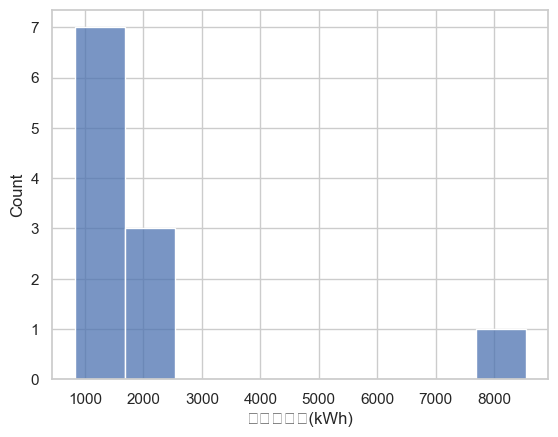

In [26]:
# 히스토그램
sns.histplot(train_00.groupby('num')['전력사용량(kWh)'].mean())

## 냉방시설은 없는데 태양광은 있는 데이터

<Axes: xlabel='전력사용량(kWh)', ylabel='Count'>

c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IP

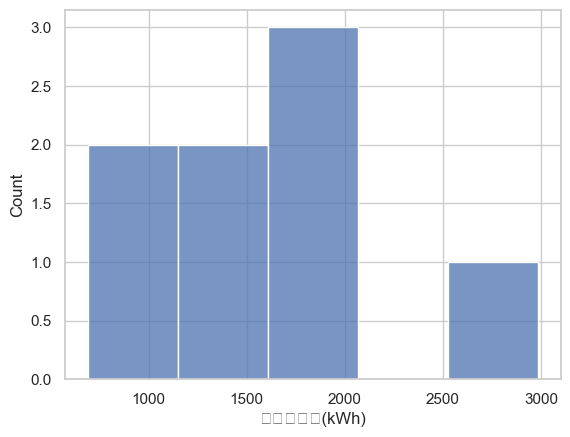

In [30]:
# 히스토그램
sns.histplot(train_01.groupby('num')['전력사용량(kWh)'].mean())

## 냉방시설은 있는데 태양광은 없는 데이터

<Axes: xlabel='전력사용량(kWh)', ylabel='Count'>

c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IP

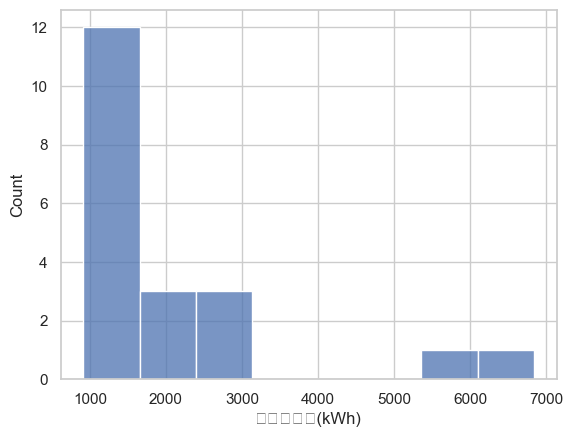

In [31]:
# 히스토그램
sns.histplot(train_10.groupby('num')['전력사용량(kWh)'].mean())

## 냉방시설도 없고 태양광도 없는 데이터

<Axes: xlabel='전력사용량(kWh)', ylabel='Count'>

c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\USER\projects\2nd_project\venv\lib\site-packages\IP

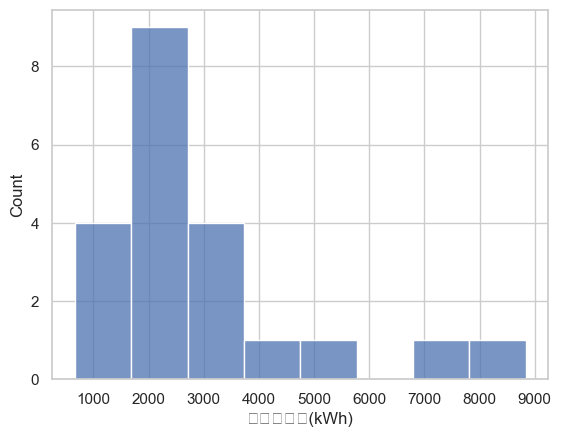

In [32]:
# 히스토그램
sns.histplot(train_11.groupby('num')['전력사용량(kWh)'].mean())